In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [42]:
import cv2
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

import shutil
import os, sys, glob

GradeCode = {
    '3+3': 0,
    '4+4': 1,
    '4+5': 2,
    'BN':  3,
    'ST':  4
}

GradeCodeInv = {
    0: '3+3',
    1: '4+4',
    2: '4+5',
    3: 'BN',
    4: 'ST'
}

# Given the annotation code, what labels are we looking for?
GradeTargets = {
    0: 0,
    1: 1,
    2: 1,
    3: 2,
    4: 3
}

epithelium_labels = [0,1,2]
proposal_labels = {
    0: 'Low Grade',
    1: 'High Grade',
    2: 'Benign',
    3: 'Stroma'
}

# prob_list = sorted(glob.glob('/Users/nathaning/Dropbox/projects/semantic_pca/figures/probs/*probability.jpg'))
# prob_list = sorted(glob.glob('/Users/nathaning/Dropbox/projects/semantic_pca/wsi_results/segnet_basic_rawprob/*RGB.png'))
# anno_list = sorted(glob.glob('/Users/nathaning/Dropbox/projects/semantic_pca/data/annotations/wsi_annotation/*.png'))

# prob_list = sorted(glob.glob('/home/nathan/histo-seg/semantic-pca/analysis_wsi/segnet_basic/*npy'))
# anno_list = sorted(glob.glob('/home/nathan/Dropbox/projects/semantic_pca/data/annotations/wsi_annotation/*.png'))

# # prob_base = [os.path.basename(os.path.splitext(pb)[0]).replace('_probability', '') for pb in prob_list]
# prob_base = [os.path.basename(os.path.splitext(pb)[0]).replace('_probability', '') for pb in prob_list]
# anno_base = [os.path.basename(os.path.splitext(ab)[0]) for ab in anno_list]

# prob_list = [p_path for pb, p_path in zip(prob_base, prob_list) if pb in anno_base]
# # prob_base = [os.path.basename(os.path.splitext(pb)[0]).replace('_probability', '') for pb in prob_list]
# prob_base = [os.path.basename(os.path.splitext(pb)[0]).replace('_probability', '') for pb in prob_list]
# anno_list = [a_path for ab, a_path in zip(anno_base, anno_list) if ab in prob_base]

# print len(prob_list), len(anno_list)

In [70]:
def class_masks(prob, mode='Argmax', thr=0.5):
    n_class = prob.shape[-1]
    if mode=='Argmax':
        prob = np.argmax(prob, axis=2)
        
    masks = [prob == n for n in range(n_class)]
    
    return masks

def eval_region(proposed, true_grade, reportf, verbose=False):
    area = np.sum(proposed)
        
    epith_area = 0.0
    st_area = proposed[-1]
    for k in epithelium_labels:
        epith_area += proposed[k]
        
    TP = proposed[GradeTargets[true_grade]]    
    if true_grade == 4:
        TP_pct = 100*TP/area
    else:
        TP_pct = 100*TP/epith_area
#     FN = epith_area - TP
#     FN_pct = 100*FN/epith_area

    report_str = 'Region graded as {} is {} total area\n'.format(GradeCodeInv[true_grade], area)
    for k in proposal_labels.iterkeys():
        report_str +=  '\t{}: {}\n'.format(proposal_labels[k], proposed[k])
    report_str += '\tEpithelium area: {}\n'.format(epith_area)
    report_str += '\tTrue postive: {:3.3f}%\n'.format(TP_pct)
    
    with open(reportf, 'a+') as f:
        f.write(report_str)

    if verbose:
        print report_str
#         print 'Region graded as {} is {} total area'.format(GradeCodeInv[true_grade], area)
#         for k in proposal_labels.iterkeys():
#             print '\t{}: {}'.format(proposal_labels[k], proposed[k])
#         print '\tEpithelium area: {}'.format(epith_area)
#         print '\tTrue postive: {:3.3f}%'.format(TP_pct)
    
    return TP_pct, area
#     print '\tFalse negative: {:3.3f}%'.format(FN_pct)

def list_matching(prob_path, anno_path):
#     prob_list = sorted(glob.glob('/home/nathan/histo-seg/semantic-pca/analysis_wsi/segnet_basic/*npy'))
#     anno_list = sorted(glob.glob('/home/nathan/Dropbox/projects/semantic_pca/data/annotations/wsi_annotation/*.png'))
    
    prob_list = sorted(glob.glob(os.path.join(prob_path, '*npy')))
    anno_list = sorted(glob.glob(os.path.join(anno_path, '*.png')))
    
    print len(prob_list), len(anno_list)

    # prob_base = [os.path.basename(os.path.splitext(pb)[0]).replace('_probability', '') for pb in prob_list]
    prob_base = [os.path.basename(os.path.splitext(pb)[0]).replace('_probability', '') for pb in prob_list]
    anno_base = [os.path.basename(os.path.splitext(ab)[0]) for ab in anno_list]

    prob_list = [p_path for pb, p_path in zip(prob_base, prob_list) if pb in anno_base]
    # prob_base = [os.path.basename(os.path.splitext(pb)[0]).replace('_probability', '') for pb in prob_list]
    prob_base = [os.path.basename(os.path.splitext(pb)[0]).replace('_probability', '') for pb in prob_list]
    anno_list = [a_path for ab, a_path in zip(anno_base, anno_list) if ab in prob_base]

    print len(prob_list), len(anno_list)
    
    return prob_list, anno_list

In [75]:
anno_path = '/home/nathan/Dropbox/projects/semantic_pca/data/annotations/wsi_annotation'


prob_dirs = ['/home/nathan/histo-seg/semantic-pca/analysis_wsi/segnet_full',
#              '/home/nathan/histo-seg/semantic-pca/analysis_wsi/segnet_basic',
#              '/home/nathan/histo-seg/semantic-pca/analysis_wsi/segnet_basic_crf',
#              '/home/nathan/histo-seg/semantic-pca/analysis_wsi/segnet_basic_rotation',
             '/home/nathan/histo-seg/semantic-pca/analysis_wsi/fcn8s',
            ]

for prob_path in prob_dirs:
    print prob_path
    prob_list, anno_list = list_matching(prob_path, anno_path)

    reportf = os.path.join(prob_path, '__report.txt')
    
    if os.path.exists(reportf):
        print 'Removing {}'.format(reportf)
        os.remove(reportf)
    
    print 'Using {}'.format(reportf)
        
    grade_results = {
        0: [],
        1: [],
        2: [],
        3: [],
        4: [],
    }

    accuracy_list = []
    area_list = []

    for ppath, apath in zip(prob_list, anno_list):
    #     ppath = prob_list[2]
    #     apath = anno_list[2]

        print os.path.basename(ppath)
        # pimg = cv2.imread(ppath, -1)
        pimg = np.load(ppath)
        aimg = cv2.imread(apath, -1)

        # print pimg.shape, pimg.min(), pimg.max()
        # print aimg.shape, aimg.min(), aimg.max(), np.unique(aimg)

        pmax = np.argmax(pimg, axis=2)
        # plt.matshow(pmax); plt.colorbar()

        masks = class_masks(pimg)
        # for mask in masks:
        #     plt.matshow(mask); plt.colorbar()

        annotations, _ = cv2.findContours((aimg<255).astype(np.uint8),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

        for anno in annotations:
        #     anno = annotations[1]
            anno_mask = np.zeros_like(aimg)
            cv2.drawContours(anno_mask, [anno], 0, (1), -1)
            anno_mask = anno_mask==1
            grade = np.unique(aimg[anno_mask])[0]
            # print grade
            # plt.matshow(anno_mask); plt.colorbar()

            # Check the content
            proposed = [(mask[anno_mask]).sum() for mask in masks]
            TP, area = eval_region(proposed, grade, reportf, verbose=False)

            grade_results[grade].append(TP)
            accuracy_list.append(TP)
            area_list.append(area)

    summarystr = ''
    for key in grade_results:
        summarystr += '{}:\t{:3.4f} +/- {:3.4f}\n'.format(GradeCodeInv[key], np.mean(grade_results[key]), np.std(grade_results[key]))
    #     print GradeCodeInv[key], ':\t', np.mean(grade_results[key]), '+/-', np.std(grade_results[key])

    print summarystr
    with open(reportf, 'a') as f:
        f.write(summarystr)
    
# plt.scatter(np.log(area_list), accuracy_list)
# plt.xlabel('Log annotation area')
# plt.ylabel('Accuracy')

/home/nathan/histo-seg/semantic-pca/analysis_wsi/segnet_full
30 30
30 30
Removing /home/nathan/histo-seg/semantic-pca/analysis_wsi/segnet_full/__report.txt
Using /home/nathan/histo-seg/semantic-pca/analysis_wsi/segnet_full/__report.txt
1304700_probability.npy
1304701_probability.npy
1304702_probability.npy
1304703_probability.npy
1304704_probability.npy
1304705_probability.npy
1304706_probability.npy
1304709_probability.npy
1304711_probability.npy
1304718_probability.npy
1305448_probability.npy
1305449_probability.npy
1305451_probability.npy
1305452_probability.npy
1305455_probability.npy
1305456_probability.npy
1305457_probability.npy
1305458_probability.npy
1305459_probability.npy
1305460_probability.npy
1305472_probability.npy
1305473_probability.npy
1305474_probability.npy
1305477_probability.npy
1305480_probability.npy
1305481_probability.npy
1305482_probability.npy
1305485_probability.npy
1305489_probability.npy
1305490_probability.npy
3+3:	90.0766 +/- 9.9573
4+4:	93.1289 +/- 7.8

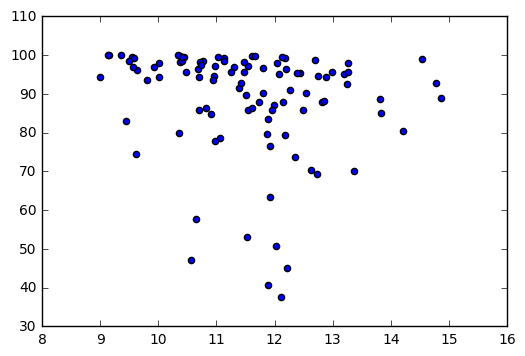

In [61]:
plt.scatter(np.log(area_list), accuracy_list)